# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
import layers

In [5]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [51]:
fcl = layers.FullyConnectedLayer(3, 4)
rl = layers.ReLULayer()

fc_out = fcl.forward(X)
rl_out = rl.forward(fc_out)
loss, grad = layers.softmax_with_cross_entropy(rl_out, np.array([[2], [3]]))

rl_grad = rl.backward(grad)
fcl.backward(rl_grad)

array([[ 0.25027059, -0.25017417, -0.25009492,  0.        ],
       [-0.50054119,  0.50034834,  0.50018983,  0.        ],
       [ 0.75081178,  0.02501742,  0.02500949,  0.        ]])

In [56]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [87]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])
# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [89]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [91]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [167]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-5)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 48.604311, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 48.137702, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 47.719709, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 47.499006, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 47.148582, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 47.087704, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.625874, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.425360, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.458473, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.517355, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.321953, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.345858, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.921689, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.810810, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.909649, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.6

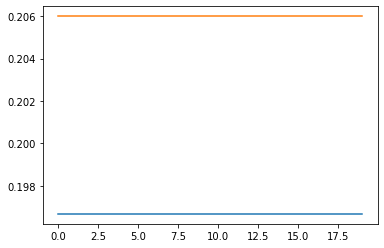

In [168]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [129]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 42.533813, Train accuracy: 0.307667, val accuracy: 0.303000
Loss: 29.044808, Train accuracy: 0.444778, val accuracy: 0.448000
Loss: 30.694454, Train accuracy: 0.466667, val accuracy: 0.491000
Loss: 35.612815, Train accuracy: 0.527222, val accuracy: 0.543000
Loss: 31.095008, Train accuracy: 0.582667, val accuracy: 0.574000
Loss: 36.012084, Train accuracy: 0.565333, val accuracy: 0.572000
Loss: 35.302729, Train accuracy: 0.551778, val accuracy: 0.533000
Loss: 30.093066, Train accuracy: 0.584000, val accuracy: 0.578000
Loss: 26.530618, Train accuracy: 0.622889, val accuracy: 0.593000
Loss: 38.297471, Train accuracy: 0.583333, val accuracy: 0.571000
Loss: 32.631292, Train accuracy: 0.617778, val accuracy: 0.609000
Loss: 34.043517, Train accuracy: 0.621000, val accuracy: 0.595000
Loss: 34.287042, Train accuracy: 0.585778, val accuracy: 0.601000
Loss: 42.360692, Train accuracy: 0.603111, val accuracy: 0.613000
Loss: 42.656437, Train accuracy: 0.618333, val accuracy: 0.585000
Loss: 31.1

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [130]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 45.478225, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.667138, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.390830, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.670050, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.882877, Train accuracy: 0.202667, val accuracy: 0.208000
Loss: 41.527208, Train accuracy: 0.243000, val accuracy: 0.244000
Loss: 44.829499, Train accuracy: 0.273556, val accuracy: 0.268000
Loss: 39.459344, Train accuracy: 0.285556, val accuracy: 0.287000
Loss: 39.931152, Train accuracy: 0.330000, val accuracy: 0.331000
Loss: 38.959392, Train accuracy: 0.384667, val accuracy: 0.379000
Loss: 33.765038, Train accuracy: 0.429111, val accuracy: 0.417000
Loss: 38.809729, Train accuracy: 0.464222, val accuracy: 0.441000
Loss: 30.889516, Train accuracy: 0.489667, val accuracy: 0.475000
Loss: 32.248849, Train accuracy: 0.516556, val accuracy: 0.509000
Loss: 33.604396, Train accuracy: 0.542444, val accuracy: 0.531000
Loss: 26.9

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [145]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=0.01, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 11.563231, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.517835, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.552843, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.472890, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.369080, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.442454, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.355635, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.323866, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.432619, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.968362, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.309406, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.523223, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.534479, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.837883, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.981531, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.1

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [155]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=0.01, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 11.579431, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.460335, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.526839, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.680437, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.029123, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.142371, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 8.809558, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 7.413398, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 10.256147, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 7.453836, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 7.189049, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 8.755959, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 6.346957, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 5.559525, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 3.954795, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 5.039667, Tr

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [198]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-4, 1e-3, 1e-2]
reg_strength = [1e-3, 1e-1, 10, 100]
learning_rate_decay = 0.999
hidden_layer_size = [256, 1024, 4096]
num_epochs = 300
batch_size = [8, 16, 32, 64]

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []


for le in learning_rates:
    for rs in reg_strength:
        for hls in hidden_layer_size:
            for bs in batch_size:
                print('############################### {} - {} - {} - {} ################################'.format(le, rs, hls, bs))
                model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hls, reg = rs)
                dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=le, num_epochs=num_epochs, batch_size=bs)

                loss_history, train_history, val_history = trainer.fit()

                if max(val_history) > best_val_accuracy:
                    best_val_accuracy = max(val_history)
                    best_classifier = model
    
    
# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

############################### 0.0001 - 0.001 - 256 - 8 ################################
Loss: 16.119796, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 15.278978, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.720001, Train accuracy: 0.400000, val accuracy: 0.000000
############################### 0.0001 - 0.001 - 256 - 16 ################################
Loss: 34.540260, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 33.670724, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 27.610002, Train accuracy: 0.400000, val accuracy: 0.000000
############################### 0.0001 - 0.001 - 256 - 32 ################################
Loss: 34.541772, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 33.616333, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 27.316893, Train accuracy: 0.400000, val accuracy: 0.000000
############################### 0.0001 - 0.001 - 256 - 64 ################################
Loss: 34.534939, Train accuracy: 0.133333, 

KeyboardInterrupt: 

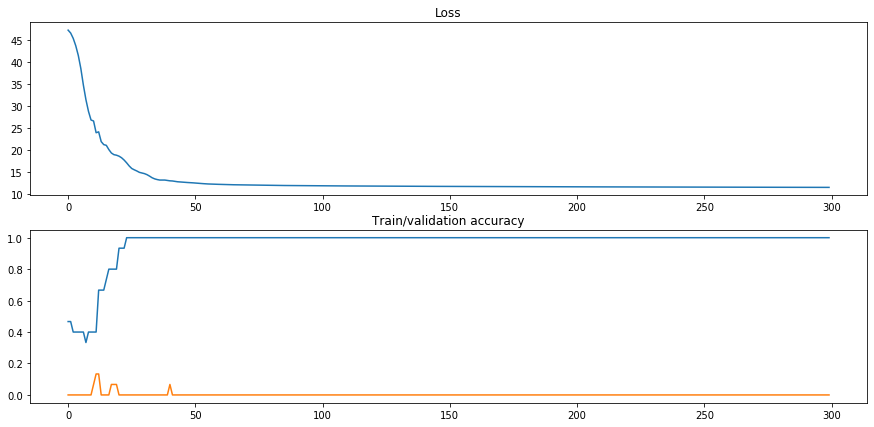

In [191]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [158]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

AttributeError: 'NoneType' object has no attribute 'predict'